# OH HfS Demonstration

Trey V. Wenger (c) June 2025

In [1]:
# General imports    
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)
print("arviz version:", az.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_hfs
print("bayes_hfs version:", bayes_hfs.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.22.0
arviz version: 0.22.0dev
bayes_spec version: 1.9.0
bayes_hfs version: 0+untagged.1.g261bad7.dirty


## Preparing Molecule Data

In [2]:
from bayes_hfs import get_molecule_data, supplement_molecule_data
import pickle

try:
    all_mol_data_OH, all_mol_metadata_OH = get_molecule_data("OH, v=0", fmin=1.6, fmax=1.8)
    with open("mol_data_OH.pkl", "wb") as f:
        pickle.dump(all_mol_data_OH, f)
    with open("metadata_OH.pkl", "wb") as f:
        pickle.dump(all_mol_metadata_OH, f)
except:
    with open("mol_data_OH.pkl", "rb") as f:
        all_mol_data_OH = pickle.load(f)
    with open("mol_metadata_OH.pkl", "rb") as f:
        all_mol_metadata_OH = pickle.load(f)

all_mol_data_OH.pprint_all()

   FREQ   ERR  LGINT   DR  ELO   GUP MOLWT TAG  QNFMT  Ju  Ku  vu F1u F2u F3u  Jl  Kl  vl F1l F2l F3l   name   Lab 
   MHz    MHz nm2 MHz     1 / cm       u                                                                           
--------- --- ------- --- ------ --- ----- ---- ----- --- --- --- --- --- --- --- --- --- --- --- --- ------- -----
1612.2309   0 -6.7758   2 0.0018   3    17 5071   325   1  -1   0   2   1  --   1   1   0   2   2  -- OH, v=0 False
1665.4018   0 -6.0487   2    0.0   3    17 5071   325   1  -1   0   2   1  --   1   1   0   2   1  -- OH, v=0 False
 1667.359   0 -5.7924   2 0.0018   5    17 5071   325   1  -1   0   2   2  --   1   1   0   2   2  -- OH, v=0 False
1720.5299   0 -6.7194   2    0.0   5    17 5071   325   1  -1   0   2   2  --   1   1   0   2   1  -- OH, v=0 False


In [3]:
all_mol_data_OH["GLO"] = 2*all_mol_data_OH["F2l"] + 1

In [4]:
mol_data_OH = supplement_molecule_data(all_mol_data_OH, all_mol_metadata_OH)
print(mol_data_OH.keys())
print("molecular weight (Daltons):", mol_data_OH['mol_weight'])
print("transition frequency (MHz):", mol_data_OH['freq'])
print("Einstein A coefficient (s-1):", mol_data_OH['Aul'])
print("Relative intensities:", mol_data_OH['relative_int'])
print("state info:", mol_data_OH["states"])
print("upper state index:", mol_data_OH["state_u_idx"])
print("lower state index:", mol_data_OH["state_l_idx"])
print("upper state degeneracy:", mol_data_OH["Gu"])
print("lower state degeneracy:", mol_data_OH["Gl"])

dict_keys(['mol_weight', 'freq', 'Aul', 'relative_int', 'states', 'state_u_idx', 'state_l_idx', 'Gu', 'Gl'])
molecular weight (Daltons): 17
transition frequency (MHz): [1612.2309 1665.4018 1667.359  1720.5299]
Einstein A coefficient (s-1): [1.26350089e-11 6.96250372e-11 7.54623971e-11 9.21216696e-12]
Relative intensities: [0.05848556 0.31199575 0.5629226  0.06659608]
state info: {'state': [np.str_('1 -1 0 2 1 --'), np.str_('1 -1 0 2 2 --'), np.str_('1 1 0 2 1 --'), np.str_('1 1 0 2 2 --')], 'deg': array([3, 5, 3, 5]), 'E': array([0.07996468, 0.08261041, 0.        , 0.0025898 ])}
upper state index: [0, 0, 1, 1]
lower state index: [3, 2, 3, 2]
upper state degeneracy: [3 3 5 5]
lower state degeneracy: [5 3 5 3]


## Simulate data

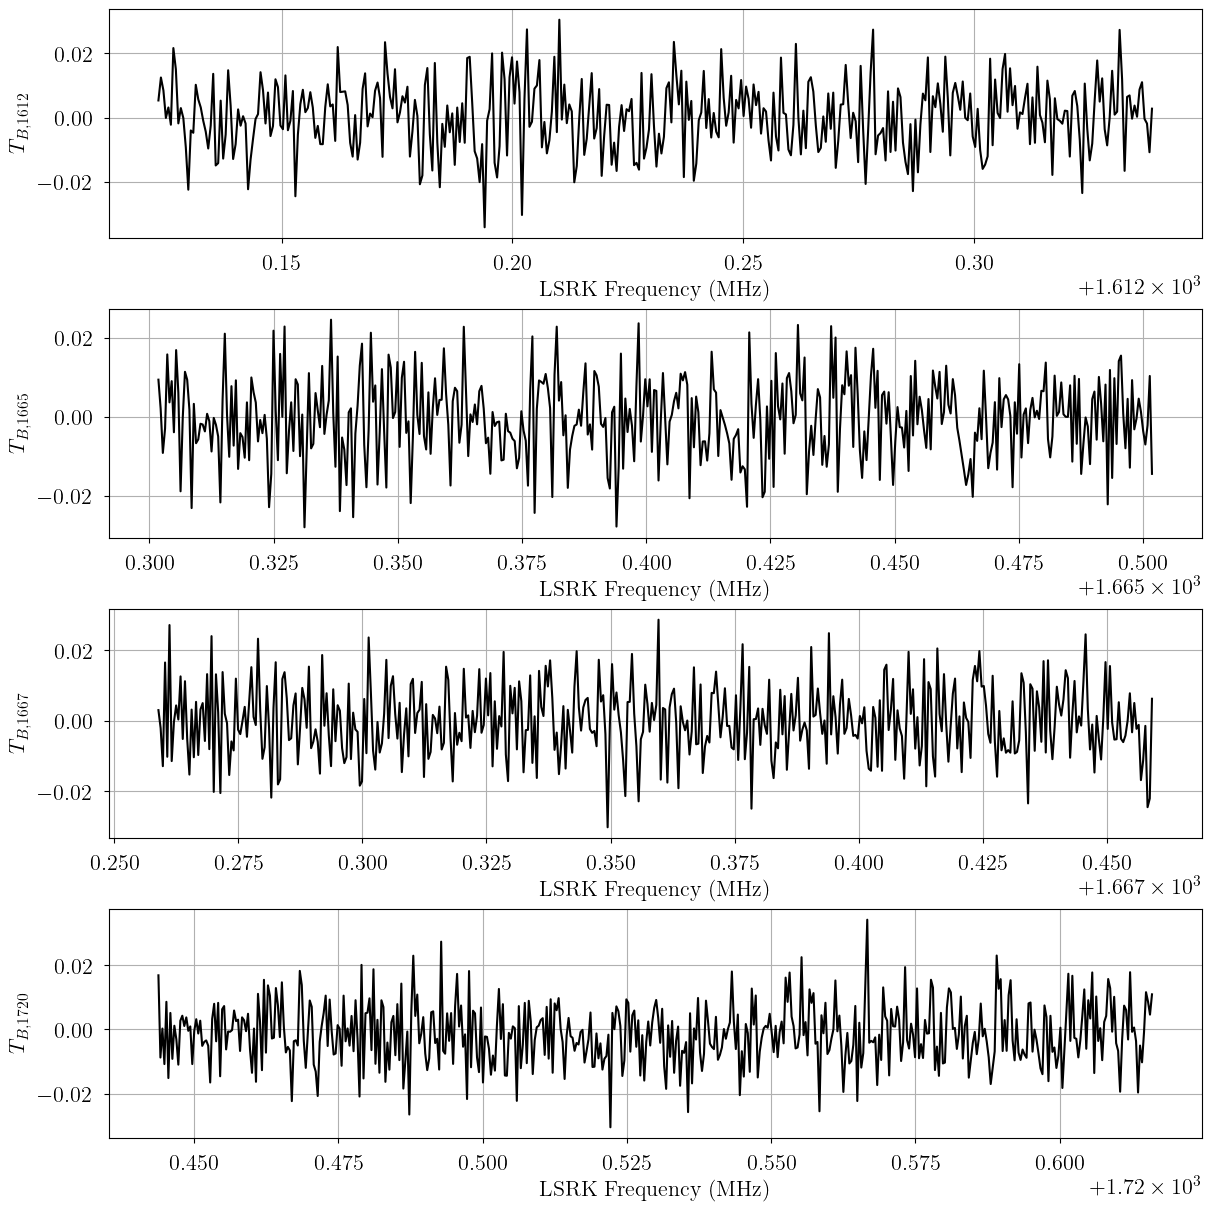

In [5]:
from bayes_spec import SpecData
import astropy.constants as c

# spectral axes definition
velo_axis = {
    "1612": np.linspace(-20.0, 20.0, 400), # km s-1
    "1665": np.linspace(-18.0, 18.0, 450),
    "1667": np.linspace(-18.0, 18.0, 450),
    "1720": np.linspace(-15.0, 15.0, 500),
}
freq_axis = {
    label: velo / c.c.to('km/s').value * freq + freq
    for label, velo, freq in zip(velo_axis.keys(), velo_axis.values(), mol_data_OH['freq'])
}

# brightness temperature (K)
rms = {
    "1612": 0.01,
    "1665": 0.01,
    "1667": 0.01,
    "1720": 0.01,
}

# brightness temperature (K)
TB = {label: rms[label] * np.random.randn(len(velo_axis[label])) for label in velo_axis.keys()}

dummy_data = {
    label: SpecData(
        freq_axis[label],
        TB[label],
        rms[label],
        xlabel=r"LSRK Frequency (MHz)",
        ylabel=r"$T_{B, {\rm "+f"{label}"+r"}}$"
    )
    for label in velo_axis.keys()
}

# Plot dummy data
fig, axes = plt.subplots(len(dummy_data), layout="constrained", figsize=(12, 12))
for ax, dummy_datum in zip(axes, dummy_data.values()):
    ax.plot(dummy_datum.spectral, dummy_datum.brightness, "k-")
    ax.set_ylabel(dummy_datum.ylabel)
    ax.set_xlabel(dummy_datum.xlabel)

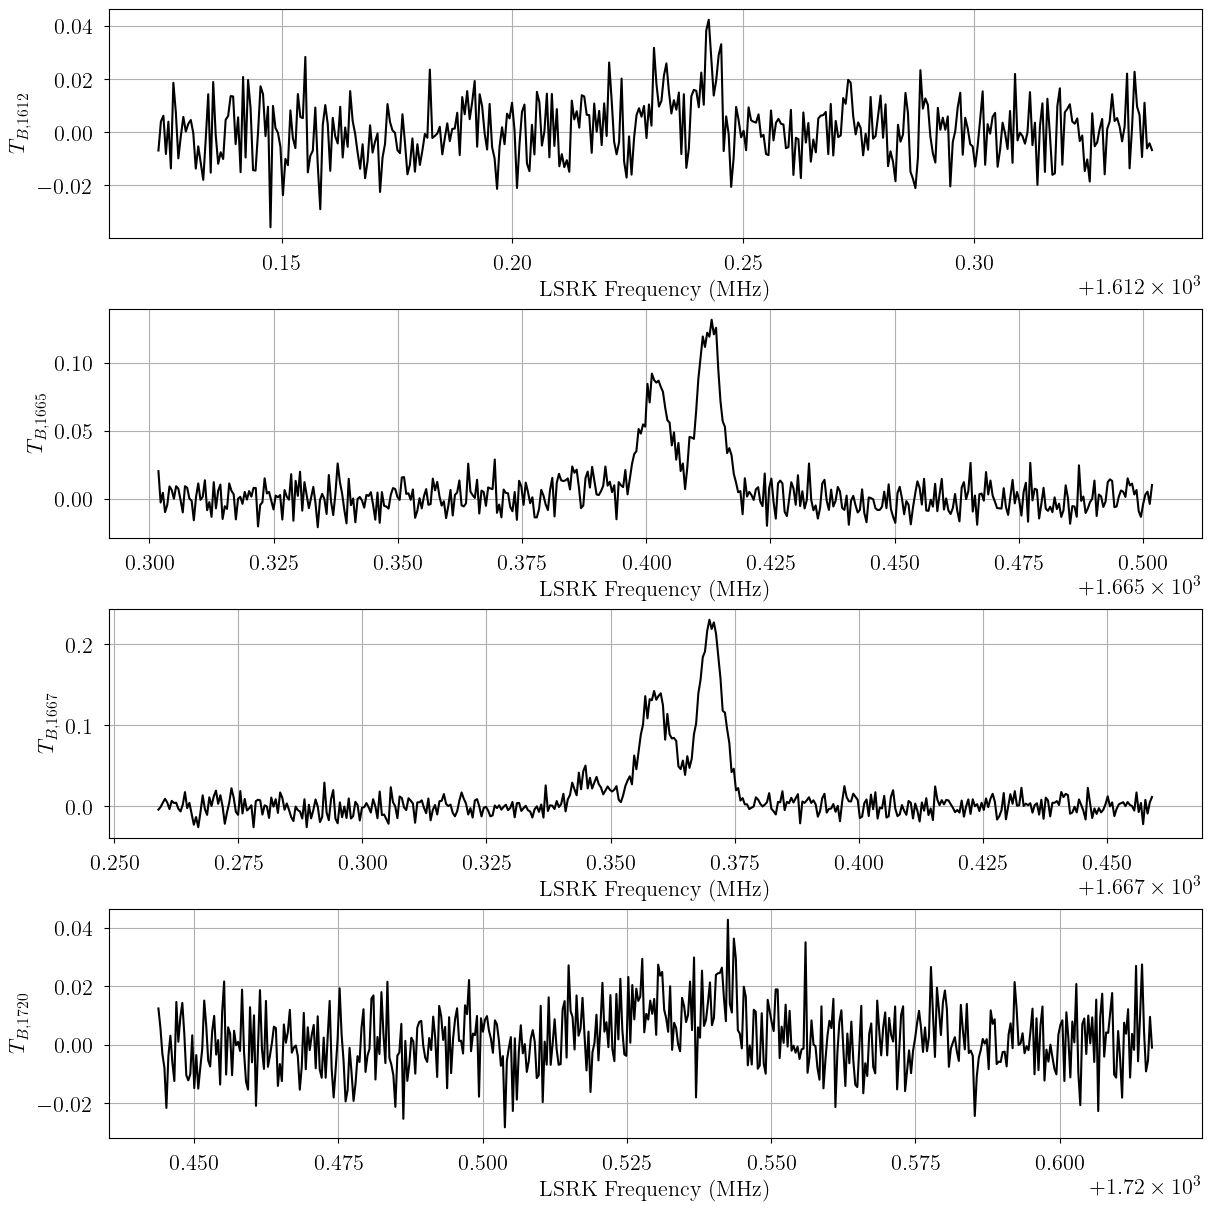

In [6]:
from bayes_hfs import HFSModel, physics

# Initialize and define the model
n_clouds = 3 # number of cloud components
baseline_degree = 0 # polynomial baseline degree
model = HFSModel(
    mol_data_OH, # molecular data
    dummy_data,
    bg_temp = 3.77, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_Ntot = [13.5, 0.5], # mean and width of log10 total column density prior (cm-2)
    prior_fwhm2 = 1.0, # width of FWHM^2 prior (km2 s-2)
    prior_velocity = [-3.0, 3.0], # upper and lower limit of velocity prior (km/s)
    prior_log10_Tex_CTEX = [0.75, 0.25], # mean and width of log10 CTEX excitation temperature prior (K)
    assume_CTEX = False, # do not assume CTEX
    prior_log10_CTEX_variance = [-6.0, 1.0], # mean and width of log10 CTEX variance
    clip_weights = 1.0e-9, # clip statistical weights between [clip_weights, 1-clip_weights]
    clip_tau = -10.0, # clip optical depths below to prevent masers
    prior_fwhm_L = None, # assume Gaussian line profile
    prior_baseline_coeffs = None, # use default baseline priors
)
model.add_likelihood()

sim_params = {
    "log10_Ntot": np.array([14.2, 14.3, 14.4]),
    "fwhm2": np.array([1.0, 1.25, 1.5])**2.0,
    "velocity": [-2.0, 0.0, 2.5],
    "log10_Tex_CTEX": np.log10([6.0, 5.0, 4.0]),
    "log10_CTEX_variance": np.array([-6.0, -6.0, -6.0]),
    "baseline_1612_norm": [0.0],
    "baseline_1665_norm": [0.0],
    "baseline_1667_norm": [0.0],
    "baseline_1720_norm": [0.0],
}

CTEX_weights = physics.calc_stat_weight(
    model.mol_data["states"]["deg"][None, :],
    model.mol_data["states"]["E"][None, :],
    10.0 ** sim_params["log10_Tex_CTEX"][:, None],
).eval()

CTEX_concentration = (
    len(model.mol_data["states"]["state"])
    * CTEX_weights
    / 10.0**sim_params["log10_CTEX_variance"][:, None]
)

from scipy.stats import dirichlet

sim_params["weights"] = np.stack([
    dirichlet(CTEX_concentration[i]).rvs()[0] for i in range(n_clouds)
])

# add derived quantities to sim_params
for key in model.cloud_deterministics:
    if key not in sim_params.keys():
        sim_params[key] = model.model[key].eval(sim_params, on_unused_input="ignore")

# Evaluate and save simulated observations
all_data = {
    label: SpecData(
        freq_axis[label],
        model.model[label].eval(sim_params, on_unused_input="ignore"),
        rms[label],
        xlabel=r"LSRK Frequency (MHz)",
        ylabel=r"$T_{B, {\rm "+f"{label}"+r"}}$"
    )
    for label in velo_axis.keys()
}

data = {
    label: SpecData(
        freq_axis[label],
        model.model[label].eval(sim_params, on_unused_input="ignore") if label != "1612" else np.ones_like(freq_axis[label]) * np.nan,
        rms[label],
        xlabel=r"LSRK Frequency (MHz)",
        ylabel=r"$T_{B, {\rm "+f"{label}"+r"}}$"
    )
    for label in velo_axis.keys()
}

# Plot data
fig, axes = plt.subplots(len(all_data), layout="constrained", figsize=(12, 12))
for ax, datum in zip(axes, all_data.values()):
    ax.plot(datum.spectral, datum.brightness, "k-")
    ax.set_ylabel(datum.ylabel)
    ax.set_xlabel(datum.xlabel)

In [7]:
sim_params

{'log10_Ntot': array([14.2, 14.3, 14.4]),
 'fwhm2': array([1.    , 1.5625, 2.25  ]),
 'velocity': [-2.0, 0.0, 2.5],
 'log10_Tex_CTEX': array([0.77815125, 0.69897   , 0.60205999]),
 'log10_CTEX_variance': array([-6., -6., -6.]),
 'baseline_1612_norm': [0.0],
 'baseline_1665_norm': [0.0],
 'baseline_1667_norm': [0.0],
 'baseline_1720_norm': [0.0],
 'weights': array([[0.18633729, 0.31030845, 0.18882411, 0.31453015],
        [0.1860613 , 0.30989336, 0.18908155, 0.3149638 ],
        [0.18566981, 0.30926722, 0.18950487, 0.3155581 ]]),
 'CTEX_weights': array([[0.18630136, 0.31036537, 0.1888009 , 0.31453237],
        [0.18606156, 0.30993855, 0.18906115, 0.31493875],
        [0.18570181, 0.30929838, 0.18945157, 0.31554824]]),
 'Tex': array([[6.09447318, 4.97398577, 3.95833562],
        [6.02877349, 4.96371015, 3.90937997],
        [5.92168013, 4.93056841, 3.97378479],
        [5.86669025, 4.92211924, 3.92554263]]),
 'tau': array([[6.55912652e-05, 1.01171087e-04, 1.60030530e-04],
        [3.5381

## Model Definition

In [8]:
# Initialize and define the model
model = HFSModel(
    mol_data_OH, # molecular data
    data,
    bg_temp = 3.77, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_Ntot = [13.5, 0.5], # mean and width of log10 total column density prior (cm-2)
    prior_fwhm2 = 1.0, # width of FWHM^2 prior (km2 s-2)
    prior_velocity = [-3.0, 3.0], # upper and lower limit of velocity prior (km/s)
    prior_log10_Tex_CTEX = [0.75, 0.25], # mean and width of log10 CTEX excitation temperature prior (K)
    assume_CTEX = False, # do not assume CTEX
    prior_log10_CTEX_variance = [-6.0, 1.0], # mean and width of log10 CTEX variance
    clip_weights = 1.0e-9, # clip statistical weights between [clip_weights, 1-clip_weights]
    clip_tau = -10.0, # clip optical depths below to prevent masers
    prior_fwhm_L = None, # assume Gaussian line profile
    prior_baseline_coeffs = None, # use default baseline priors
)
model.add_likelihood()

/home/twenger/miniforge3/envs/bayes_spec-dev/lib/python3.13/site-packages/pymc/model/core.py:1311: ImputationWarning: Data in 1612 contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


Sampling: [1612_observed, 1612_unobserved, 1665, 1667, 1720, baseline_1612_norm, baseline_1665_norm, baseline_1667_norm, baseline_1720_norm, fwhm2_norm, log10_CTEX_variance_norm, log10_Ntot_norm, log10_Tex_CTEX_norm, velocity_norm, weights]


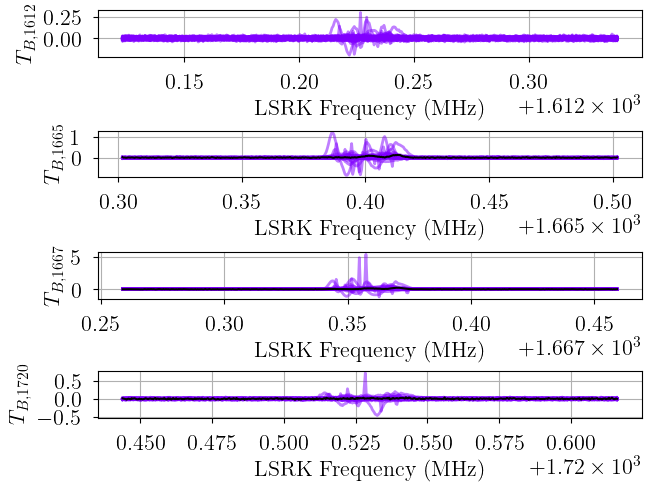

In [9]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=1000,  # prior predictive samples
)
prior.prior_predictive["1612"] = prior.prior["1612_unobserved"]
_ = plot_predictive(model.data, prior.prior_predictive.sel(draw=slice(None, None, 20)))

In [10]:
print(model.cloud_freeRVs)
print(model.cloud_deterministics)

['log10_Ntot_norm', 'fwhm2_norm', 'velocity_norm', 'log10_Tex_CTEX_norm', 'log10_CTEX_variance_norm', 'weights']
['log10_Ntot', 'fwhm2', 'velocity', 'log10_Tex_CTEX', 'CTEX_weights', 'log10_CTEX_variance', 'Tex', 'tau', 'tau_total', 'TR']


['log10_Ntot', 'fwhm2', 'velocity', 'log10_Tex_CTEX', 'log10_CTEX_variance', 'tau_total']


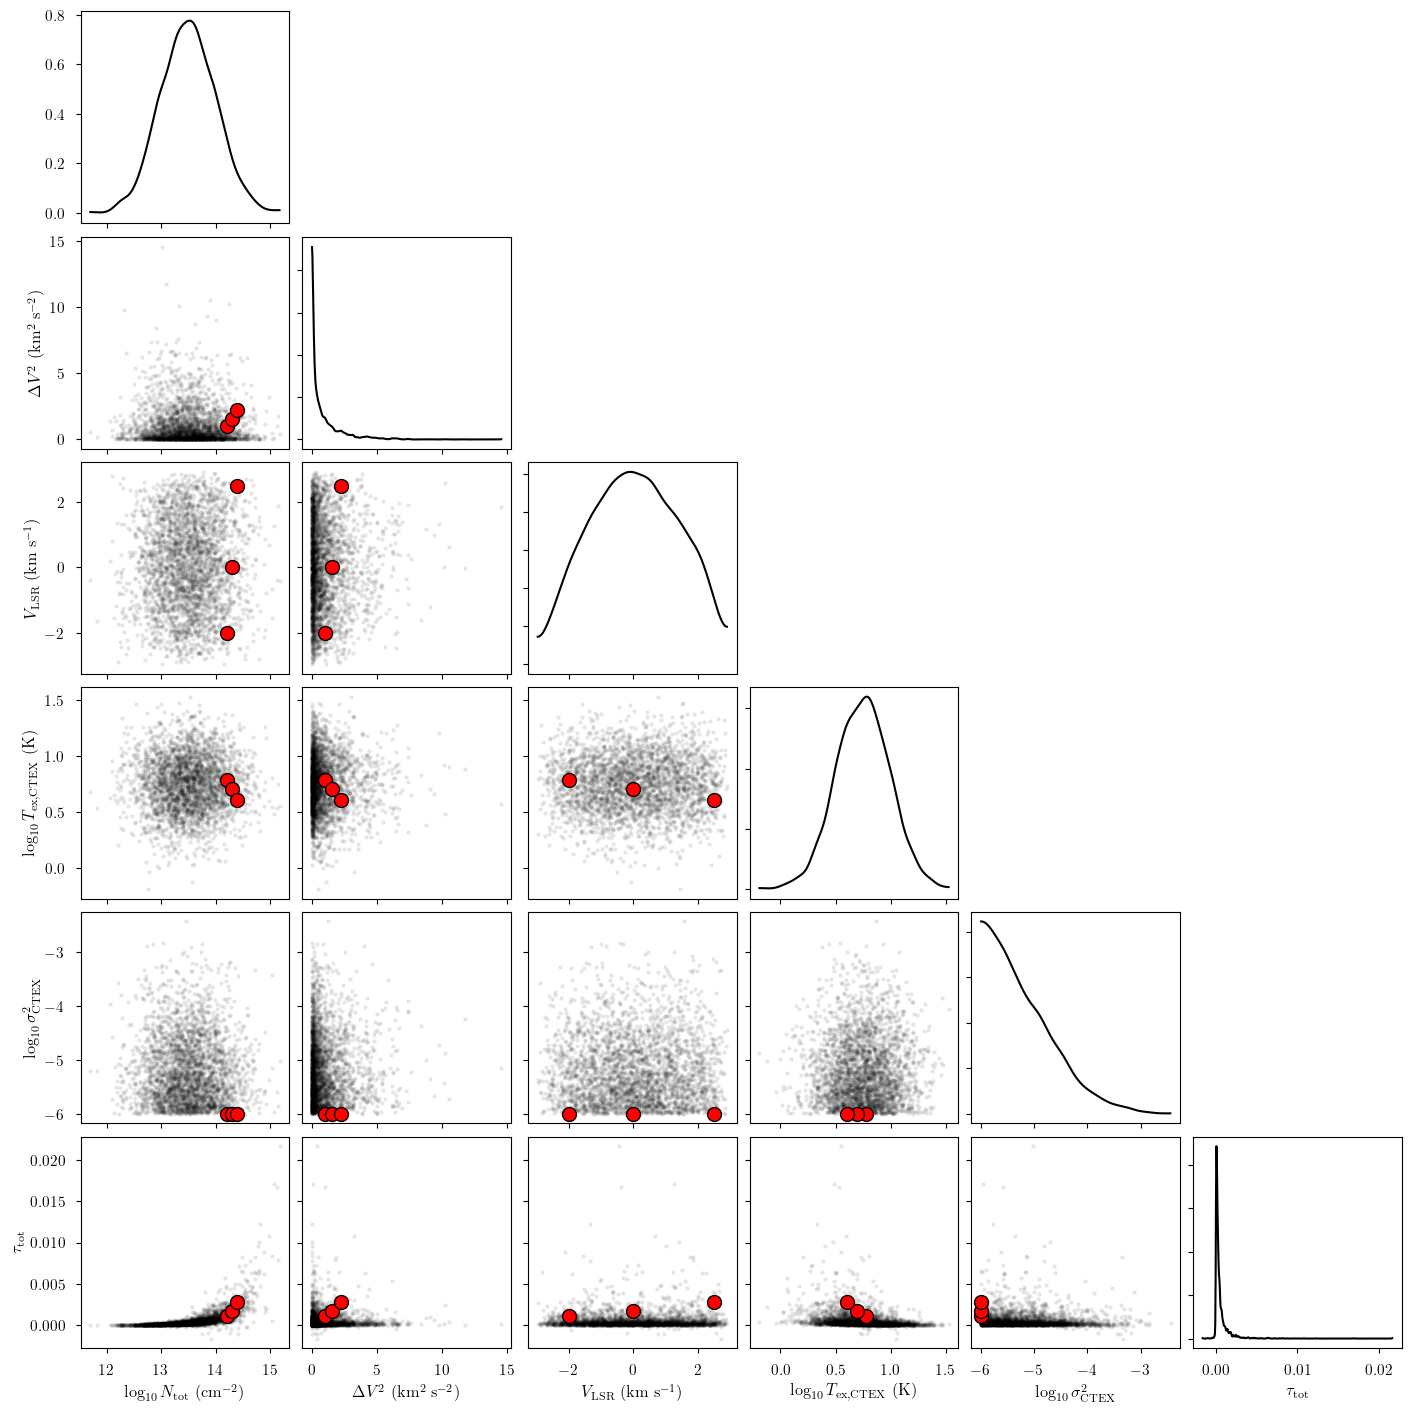

In [11]:
from bayes_spec.plots import plot_pair

var_names = [
    param for param in model.cloud_deterministics + [p for p in model.cloud_freeRVs if "_norm" not in p]
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state"]))
]
print(var_names)
_ = plot_pair(
    prior.prior, # samples
    var_names, # var_names to plot
    combine_dims=["cloud"], # concatenate clouds
    labeller=model.labeller, # label manager
    kind="scatter", # plot type
    reference_values=sim_params, # truths
)

## Variational Inference

In [12]:
start = time.time()
model.fit(
    n = 200_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.01, # VI absolute convergence threshold
    learning_rate = 0.001, # VI learning rate
    start = {"velocity_norm": np.linspace(0.1, 0.9, model.n_clouds)},
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 29200
Interrupted at 29,199 [14%]: Average Loss = 8.3454e+50


Adding log-likelihood to trace


Output()

Runtime: 6.40 minutes


In [13]:
pm.summary(model.trace.posterior)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
baseline_1612_norm[0]           -0.042  0.050  -0.134    0.048      0.002   
baseline_1665_norm[0]            0.049  0.046  -0.033    0.136      0.001   
baseline_1667_norm[0]            0.012  0.046  -0.080    0.097      0.001   
baseline_1720_norm[0]            0.064  0.046  -0.017    0.155      0.001   
log10_Ntot_norm[0]              -2.736  0.011  -2.756   -2.715      0.000   
log10_Ntot_norm[1]              -2.762  0.015  -2.791   -2.733      0.000   
log10_Ntot_norm[2]              -2.701  0.068  -2.827   -2.574      0.002   
log10_Tex_CTEX_norm[0]           0.067  1.007  -1.777    1.955      0.032   
log10_Tex_CTEX_norm[1]           0.084  0.976  -1.610    1.955      0.030   
log10_Tex_CTEX_norm[2]           0.296  0.935  -1.383    2.057      0.029   
1612_unobserved[0]              -0.001  0.010  -0.020    0.018      0.000   
1612_unobserved[1]               0.001  0.010  -0.018    0.019      0.000   
1612_unobserved[2]              -0.000  0.010  -0.017    0.018      0.000   
1612_unobserved[3]              -0.000  0.010  -0.018    0.018      0.000   
1612_unobserved[4]              -0.002  0.010  -0.021    0.017      0.000   
1612_unobserved[5]               0.000  0.010  -0.018    0.019      0.000   
1612_unobserved[6]              -0.001  0.010  -0.020    0.018      0.000   
1612_unobserved[7]              -0.001  0.010  -0.020    0.018      0.000   
1612_unobserved[8]               0.000  0.010  -0.020    0.017      0.000   
1612_unobserved[9]              -0.000  0.010  -0.020    0.018      0.000   
1612_unobserved[10]              0.001  0.010  -0.017    0.020      0.000   
1612_unobserved[11]             -0.000  0.010  -0.019    0.018      0.000   
1612_unobserved[12]             -0.000  0.010  -0.019    0.020      0.000   
1612_unobserved[13]             -0.001  0.010  -0.022    0.016      0.000   
1612_unobserved[14]              0.000  0.010  -0.017    0.020      0.000   
1612_unobserved[15]             -0.000  0.010  -0.018    0.021      0.000   
1612_unobserved[16]             -0.001  0.010  -0.019    0.019      0.000   
1612_unobserved[17]             -0.002  0.010  -0.023    0.016      0.000   
1612_unobserved[18]             -0.001  0.010  -0.021    0.017      0.000   
1612_unobserved[19]             -0.000  0.010  -0.020    0.019      0.000   
1612_unobserved[20]              0.000  0.010  -0.018    0.020      0.000   
1612_unobserved[21]              0.000  0.010  -0.020    0.016      0.000   
1612_unobserved[22]             -0.001  0.010  -0.020    0.019      0.000   
1612_unobserved[23]             -0.000  0.010  -0.018    0.021      0.000   
1612_unobserved[24]              0.001  0.010  -0.017    0.019      0.000   
1612_unobserved[25]             -0.001  0.010  -0.021    0.017      0.000   
1612_unobserved[26]             -0.001  0.010  -0.019    0.018      0.000   
1612_unobserved[27]             -0.001  0.010  -0.022    0.017      0.000   
1612_unobserved[28]             -0.000  0.010  -0.018    0.021      0.000   
1612_unobserved[29]             -0.001  0.010  -0.021    0.018      0.000   
1612_unobserved[30]              0.001  0.010  -0.018    0.021      0.000   
1612_unobserved[31]             -0.001  0.010  -0.020    0.020      0.000   
1612_unobserved[32]             -0.001  0.011  -0.020    0.018      0.000   
1612_unobserved[33]              0.000  0.010  -0.017    0.019      0.000   
1612_unobserved[34]              0.001  0.010  -0.020    0.020      0.000   
1612_unobserved[35]             -0.001  0.010  -0.019    0.019      0.000   
1612_unobserved[36]             -0.001  0.011  -0.021    0.019      0.000   
1612_unobserved[37]             -0.001  0.011  -0.020    0.020      0.000   
1612_unobserved[38]             -0.001  0.010  -0.019    0.018      0.000   
1612_unobserved[39]              0.001  0.011  -0.018    0.021      0.000   
1612_unobserved[40]             -0.001  0.011  -0.019    0.020      0.000   
1612_unobserved[41]           

Sampling: [1612_observed, 1612_unobserved, 1665, 1667, 1720]


Output()

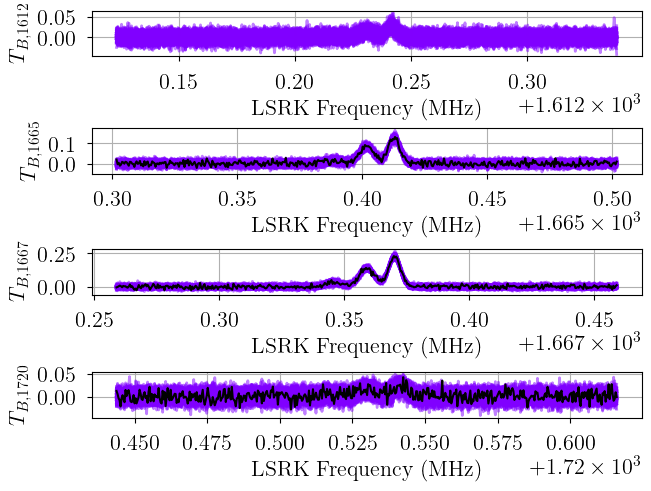

In [14]:
posterior = model.sample_posterior_predictive(
    thin=10, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

## MCMC
We increase `target_accept` since this model has some degeneracies.

In [15]:
start = time.time()
model.sample(
    init="advi+adapt_diag",  # initialization strategy
    tune=1000,  # tuning samples
    draws=1000,  # posterior samples
    chains=8,  # number of independent chains
    cores=8,  # number of parallel chains
    init_kwargs={
        "rel_tolerance": 0.01,
        "abs_tolerance": 0.01,
        "learning_rate": 0.001,
        "start": {"velocity_norm": np.linspace(0.1, 0.9, model.n_clouds)},
    },  # VI initialization arguments
    nuts_kwargs={"target_accept": 0.8},  # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 29200
Interrupted at 29,199 [2%]: Average Loss = 8.3454e+50
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_1612_norm, baseline_1665_norm, baseline_1667_norm, baseline_1720_norm, log10_Ntot_norm, fwhm2_norm, velocity_norm, log10_Tex_CTEX_norm, log10_CTEX_variance_norm, weights, 1612_unobserved]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 823 seconds.


Adding log-likelihood to trace


Output()

There were 352 divergences in converged chains.
Runtime: 20.76 minutes


In [16]:
model.solve(
    init_params="random_from_data", # GMM initialization strategy
    n_init=10, # number of GMM initilizations
    max_iter=1_000, # maximum number of GMM iterations
    kl_div_threshold=0.1, # covergence threshold
)

GMM converged to unique solution


In [17]:
print("solutions:", model.solutions)
az.summary(model.trace.solution_0)
# this also works: az.summary(model.trace.solution_0)

solutions: [0]


mean       sd  hdi_3%  hdi_97%  mcse_mean  \
baseline_1612_norm[0]           -0.167    0.909  -1.830    1.475      0.205   
baseline_1665_norm[0]            0.039    0.052  -0.055    0.140      0.001   
baseline_1667_norm[0]            0.005    0.050  -0.092    0.099      0.000   
baseline_1720_norm[0]            0.056    0.046  -0.033    0.141      0.001   
log10_Ntot_norm[0]               0.918    0.262   0.487    1.484      0.015   
log10_Ntot_norm[1]               0.755    0.253   0.330    1.273      0.007   
log10_Ntot_norm[2]              -0.330    0.390  -0.944    0.493      0.008   
log10_Tex_CTEX_norm[0]           1.028    0.691  -0.231    2.251      0.022   
log10_Tex_CTEX_norm[1]           0.999    0.681  -0.180    2.274      0.014   
log10_Tex_CTEX_norm[2]           0.607    0.690  -0.571    1.834      0.012   
1612_unobserved[0]              -0.002    0.013  -0.026    0.024      0.002   
1612_unobserved[1]              -0.002    0.013  -0.026    0.024      0.002   
1612_unobserved[2]              -0.002    0.013  -0.026    0.025      0.002   
1612_unobserved[3]              -0.002    0.014  -0.027    0.024      0.002   
1612_unobserved[4]              -0.002    0.013  -0.026    0.024      0.002   
1612_unobserved[5]              -0.002    0.013  -0.027    0.023      0.002   
1612_unobserved[6]              -0.002    0.014  -0.027    0.023      0.002   
1612_unobserved[7]              -0.002    0.013  -0.027    0.023      0.002   
1612_unobserved[8]              -0.002    0.013  -0.027    0.023      0.002   
1612_unobserved[9]              -0.002    0.014  -0.027    0.024      0.002   
1612_unobserved[10]             -0.002    0.013  -0.026    0.024      0.002   
1612_unobserved[11]             -0.002    0.013  -0.027    0.023      0.002   
1612_unobserved[12]             -0.002    0.013  -0.028    0.023      0.002   
1612_unobserved[13]             -0.002    0.013  -0.026    0.024      0.002   
1612_unobserved[14]             -0.002    0.014  -0.026    0.025      0.002   
1612_unobserved[15]             -0.001    0.014  -0.025    0.027      0.002   
1612_unobserved[16]             -0.002    0.013  -0.027    0.023      0.002   
1612_unobserved[17]             -0.002    0.014  -0.028    0.022      0.002   
1612_unobserved[18]             -0.002    0.013  -0.026    0.025      0.002   
1612_unobserved[19]             -0.001    0.013  -0.026    0.023      0.002   
1612_unobserved[20]             -0.002    0.013  -0.026    0.024      0.002   
1612_unobserved[21]             -0.002    0.014  -0.027    0.023      0.002   
1612_unobserved[22]             -0.002    0.013  -0.027    0.023      0.002   
1612_unobserved[23]             -0.002    0.013  -0.027    0.023      0.002   
1612_unobserved[24]             -0.001    0.014  -0.027    0.024      0.002   
1612_unobserved[25]             -0.002    0.014  -0.027    0.023      0.002   
1612_unobserved[26]             -0.002    0.013  -0.026    0.024      0.002   
1612_unobserved[27]             -0.002    0.013  -0.027    0.023      0.002   
1612_unobserved[28]             -0.002    0.013  -0.026    0.024      0.002   
1612_unobserved[29]             -0.002    0.014  -0.027    0.024      0.002   
1612_unobserved[30]             -0.001    0.013  -0.028    0.023      0.002   
1612_unobserved[31]             -0.001    0.014  -0.026    0.024      0.002   
1612_unobserved[32]             -0.002    0.014  -0.027    0.024      0.002   
1612_unobserved[33]             -0.002    0.014  -0.027    0.023      0.002   
1612_unobserved[34]             -0.002    0.013  -0.027    0.024      0.002   
1612_unobserved[35]             -0.002    0.013  -0.026    0.024      0.002   
1612_unobserved[36]             -0.001    0.013  -0.026    0.024      0.002   
1612_unobserved[37]             -0.002    0.013  -0.026    0.023      0.002   
1612_unobserved[38]             -0.002    0.014  -0.027    0.024      0.002   
1612_unobserved[39]             -0.002    0.013  -0.026    0.023      0.002   
1612_

Sampling: [1612_observed, 1612_unobserved, 1665, 1667, 1720]


Output()

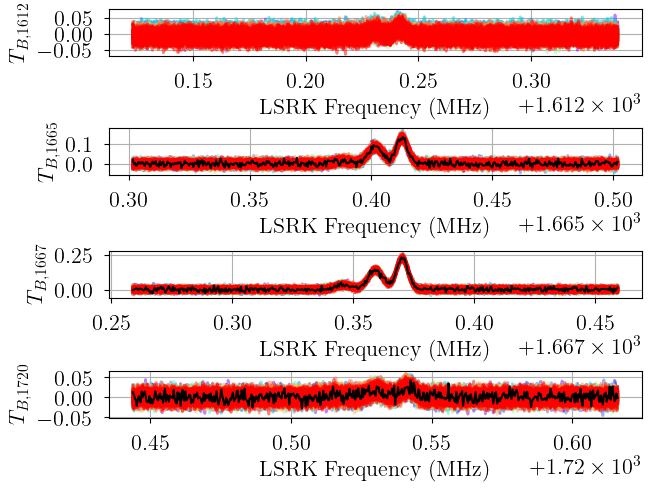

In [18]:
posterior = model.sample_posterior_predictive(
    thin=10, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

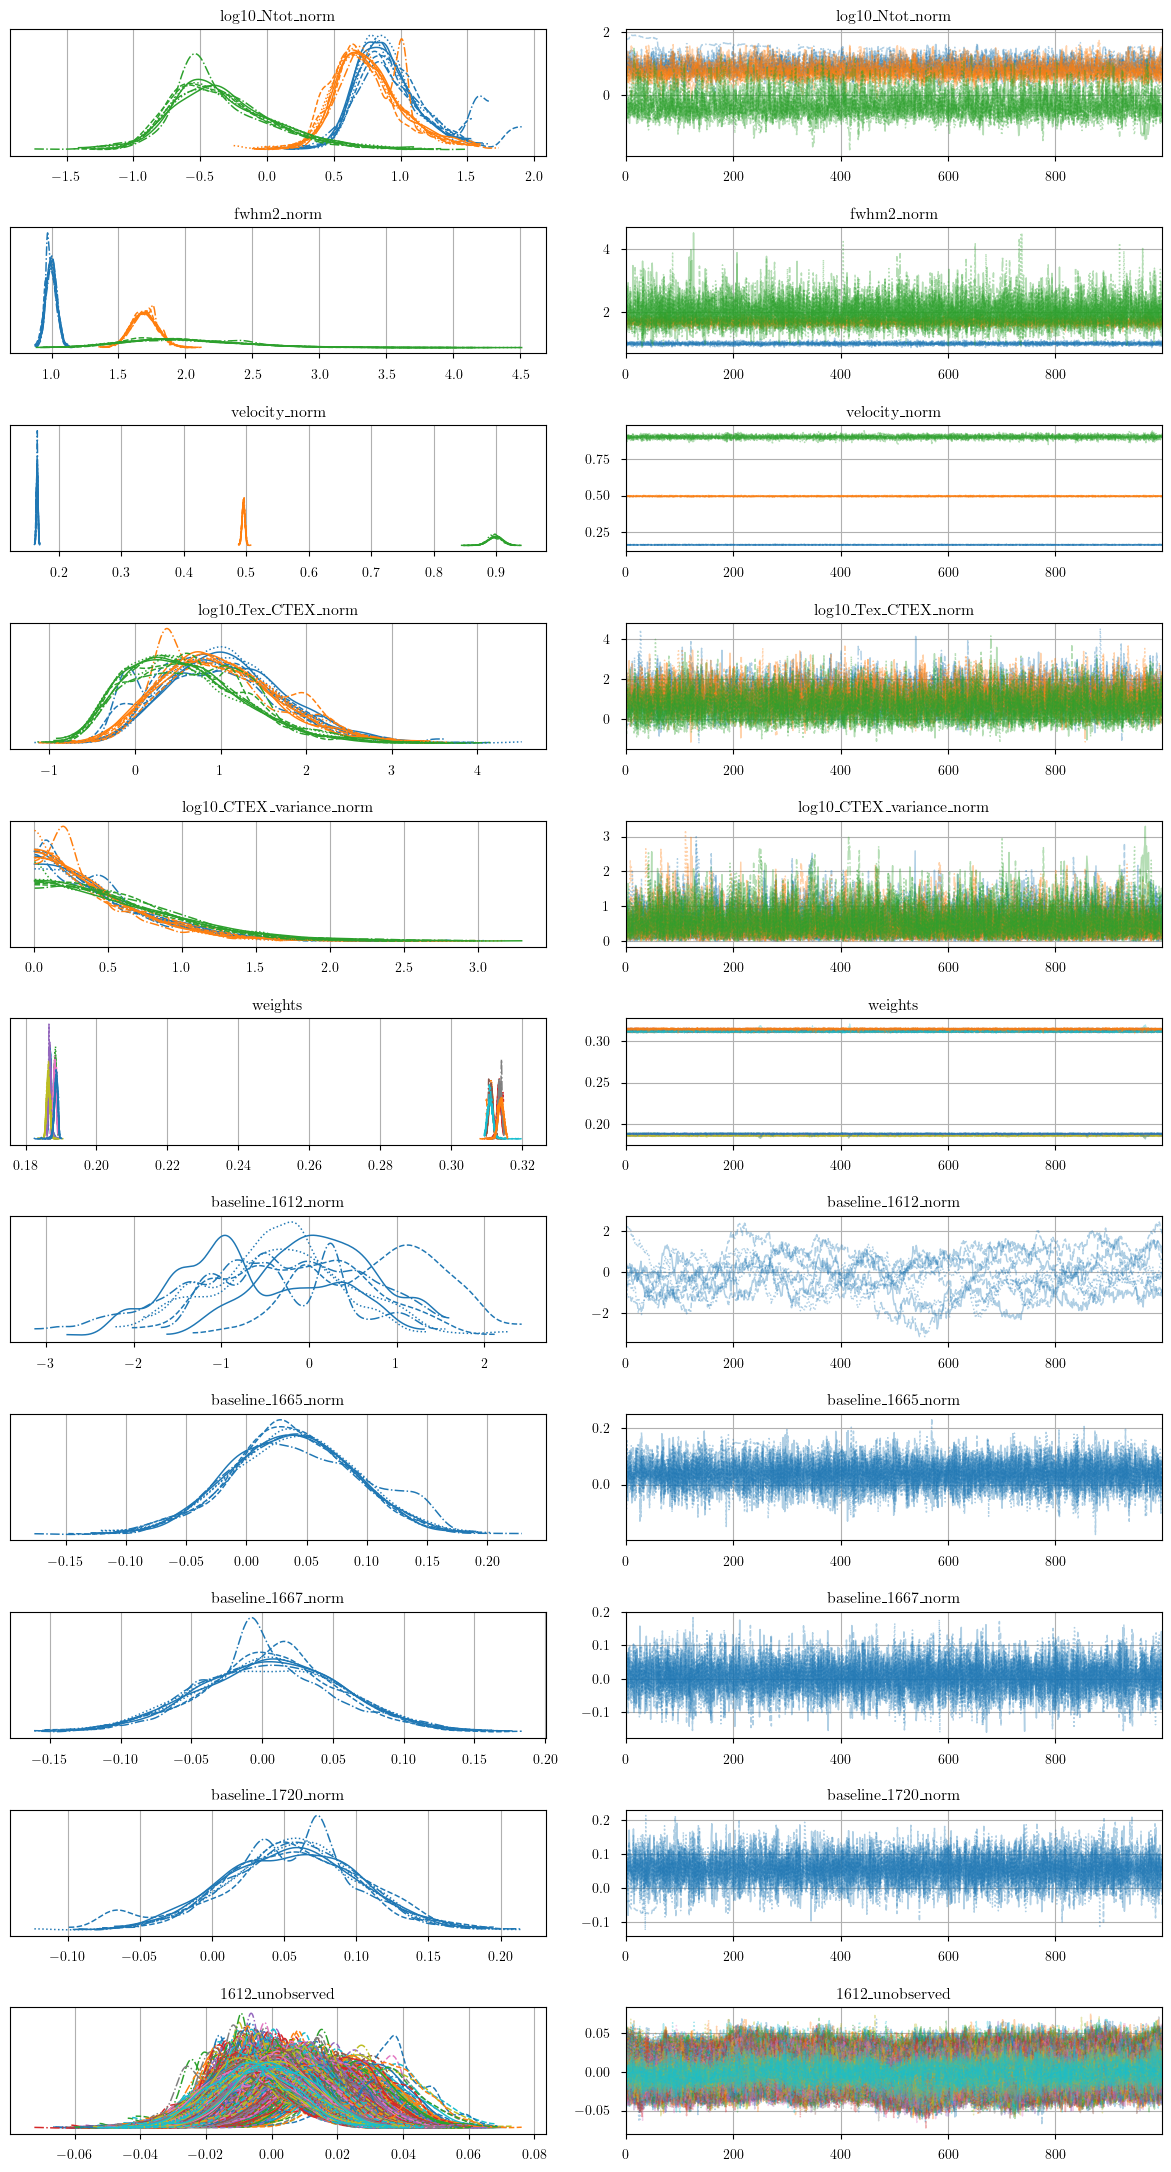

In [19]:
from bayes_spec.plots import plot_traces

axes = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)
fig = axes.ravel()[0].figure
fig.tight_layout()

['log10_Ntot_norm', 'fwhm2_norm', 'velocity_norm', 'log10_Tex_CTEX_norm', 'log10_CTEX_variance_norm']


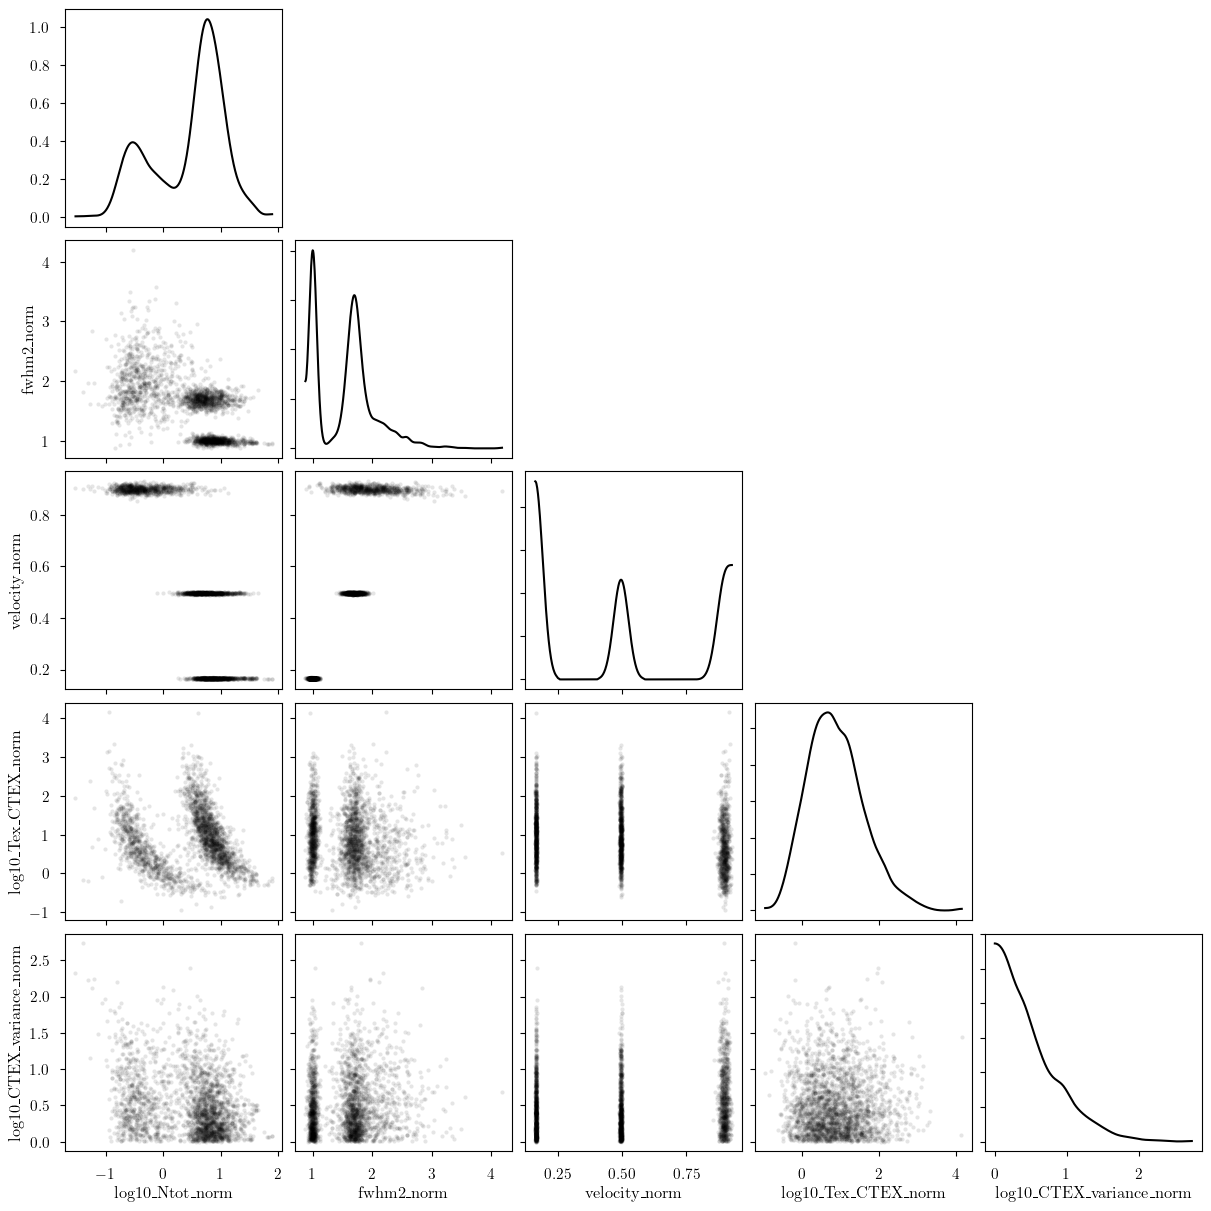

In [20]:
var_names = [
    param for param in model.cloud_freeRVs
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state"]))
]
print(var_names)
_ = plot_pair(
    model.trace.solution_0.sel(draw=slice(None, None, 10)), # samples
    var_names, # var_names to plot
    combine_dims=["cloud"], # concatenate clouds
    kind="scatter", # plot type
)

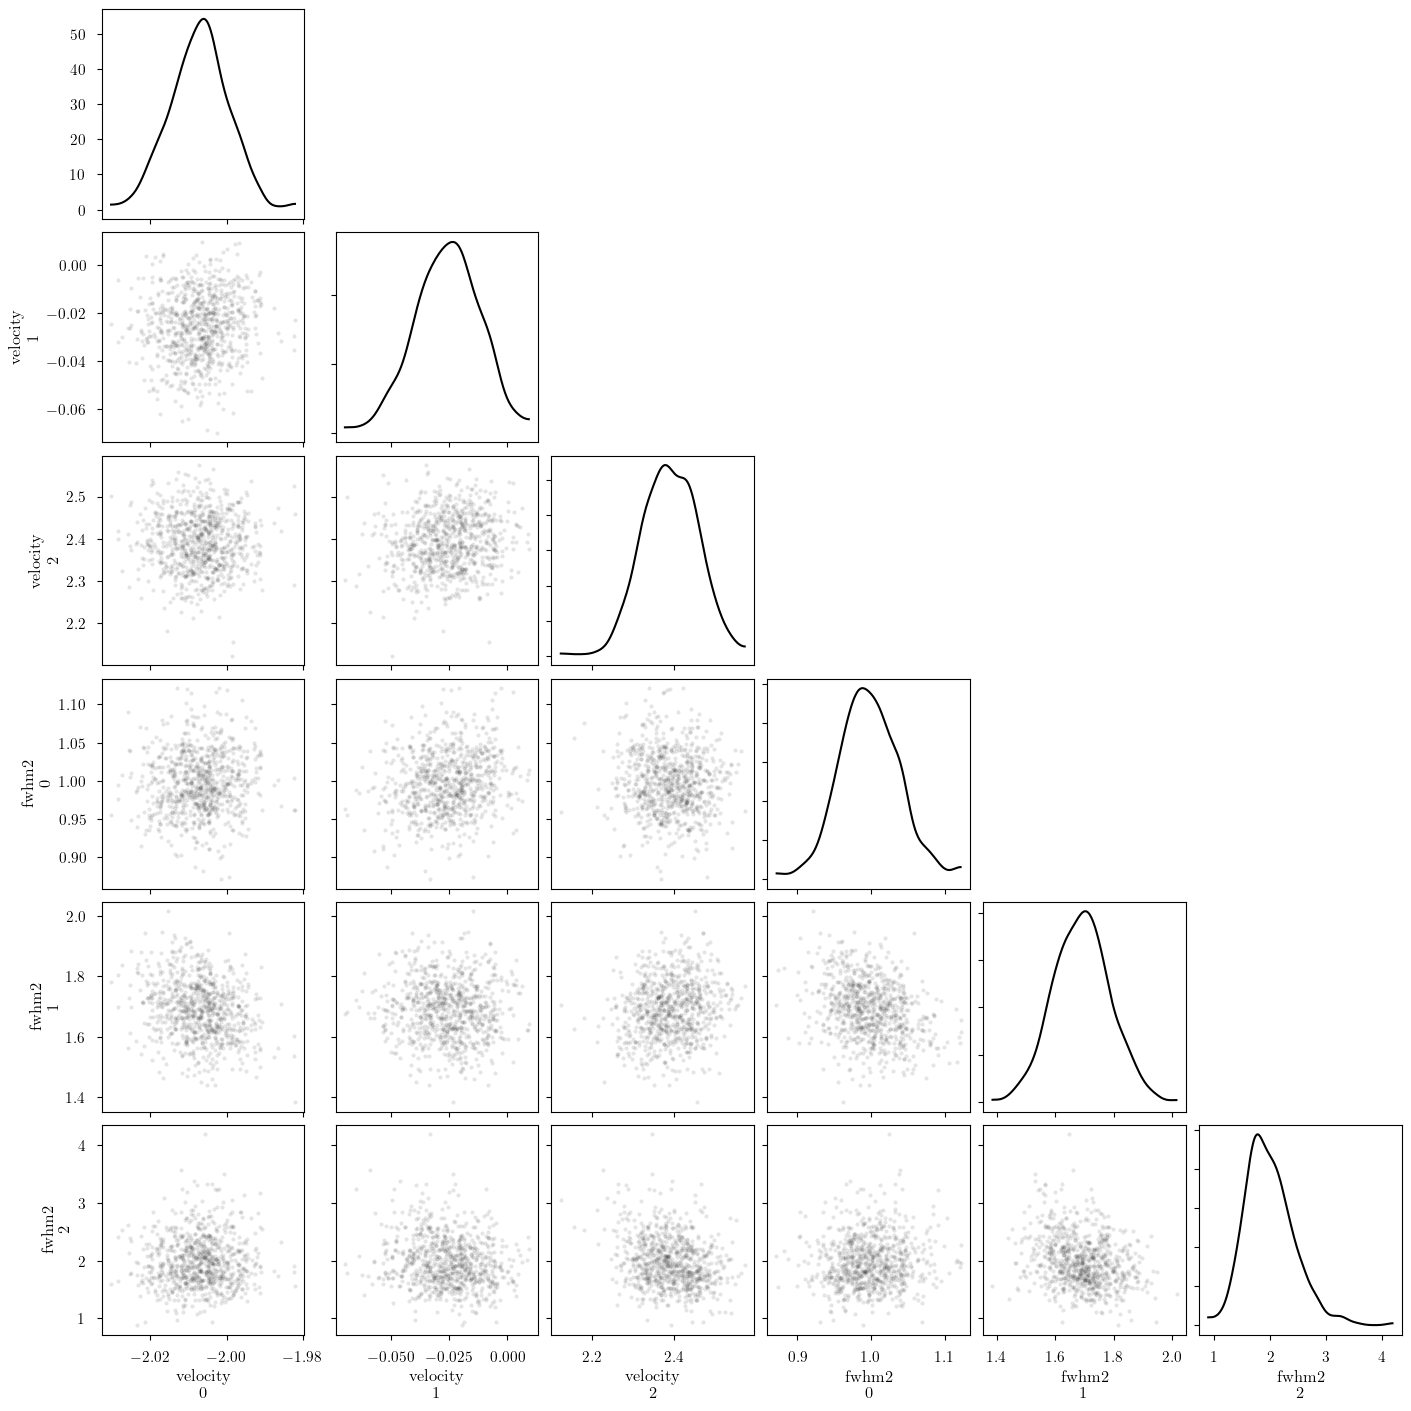

In [21]:
_ = plot_pair(
    model.trace.solution_0.sel(draw=slice(None, None, 10)), # samples
    ["velocity", "fwhm2"], # var_names to plot
    combine_dims=None, # do not concatenate clouds
    kind="scatter", # plot type
)

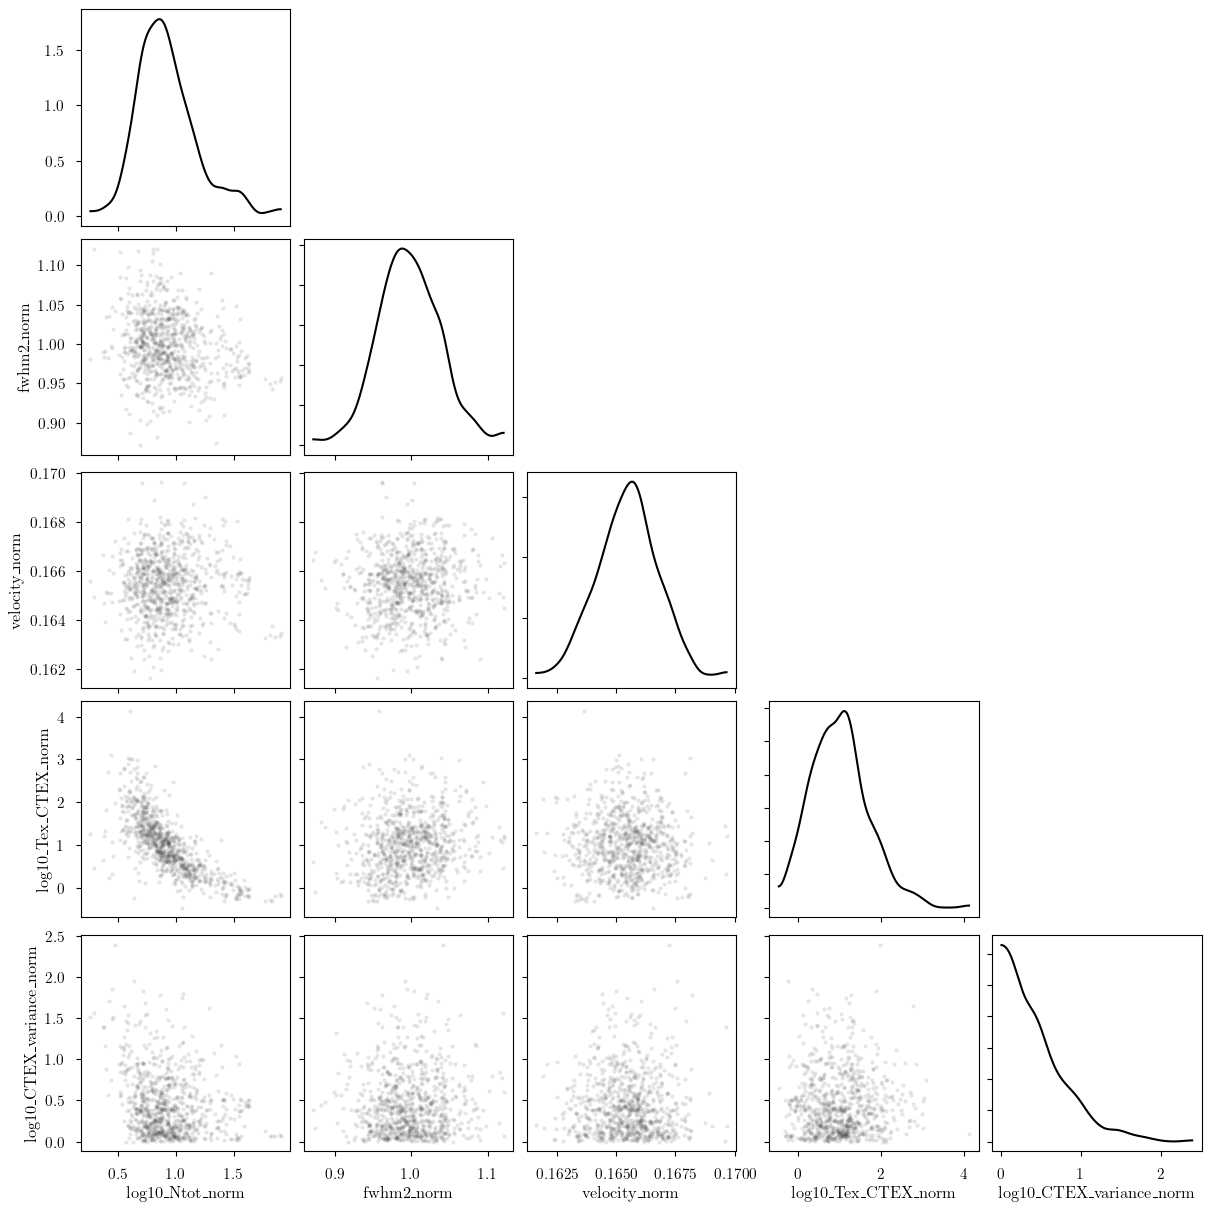

In [22]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=0, draw=slice(None, None, 10)), # samples
    var_names, # var_names to plot
    kind="scatter", # plot type
)

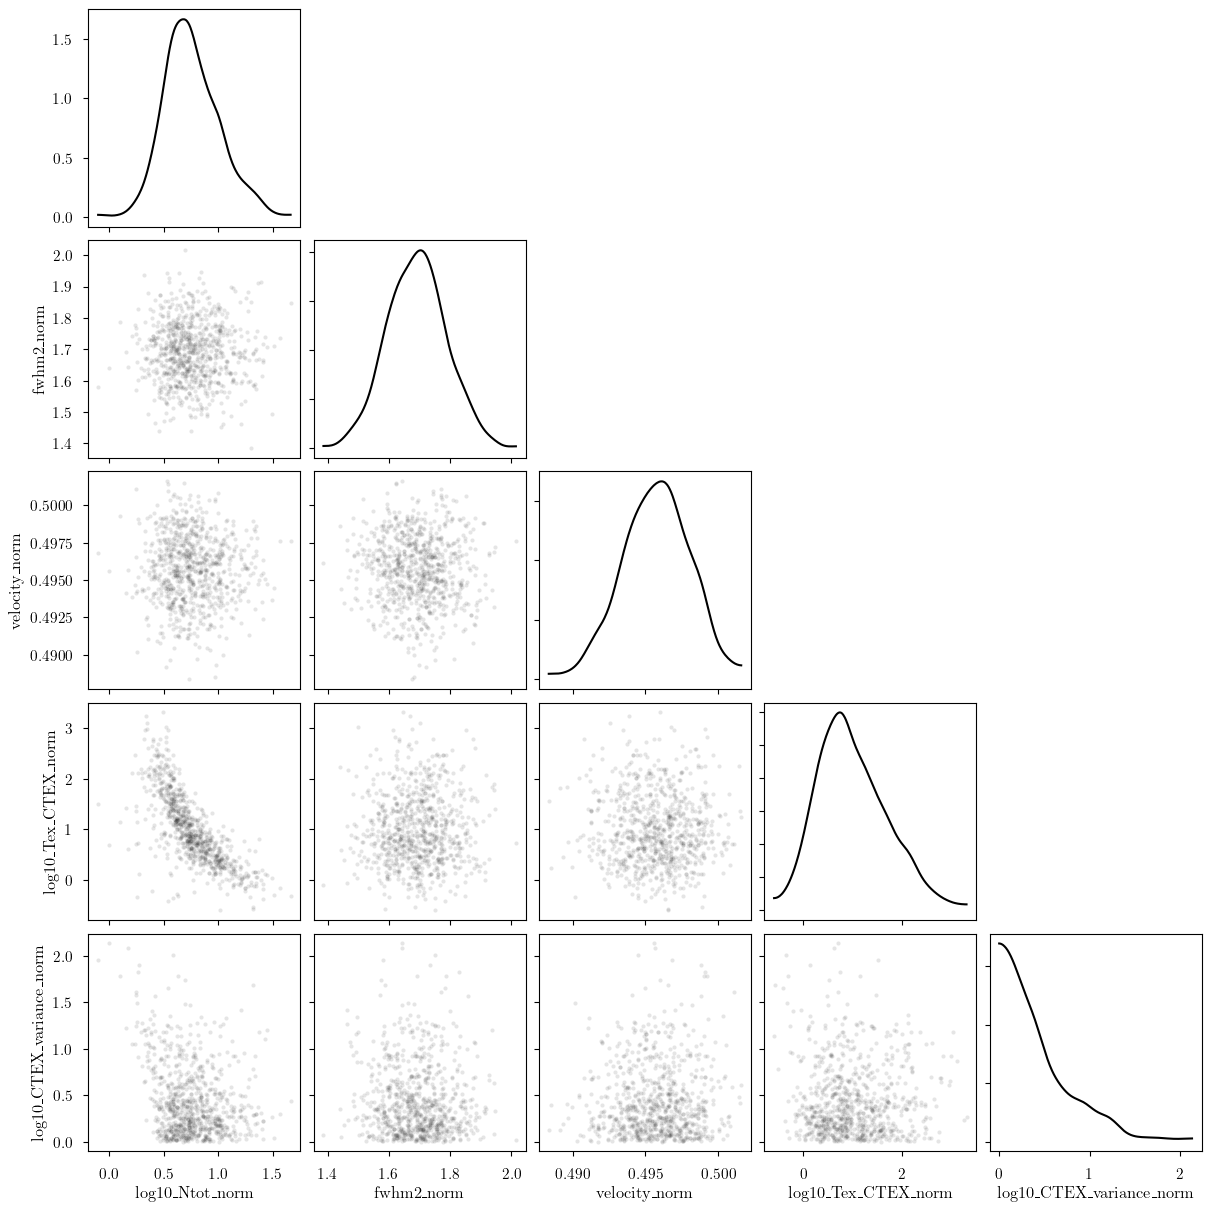

In [23]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=1, draw=slice(None, None, 10)), # samples
    var_names, # var_names to plot
    kind="scatter", # plot type
)

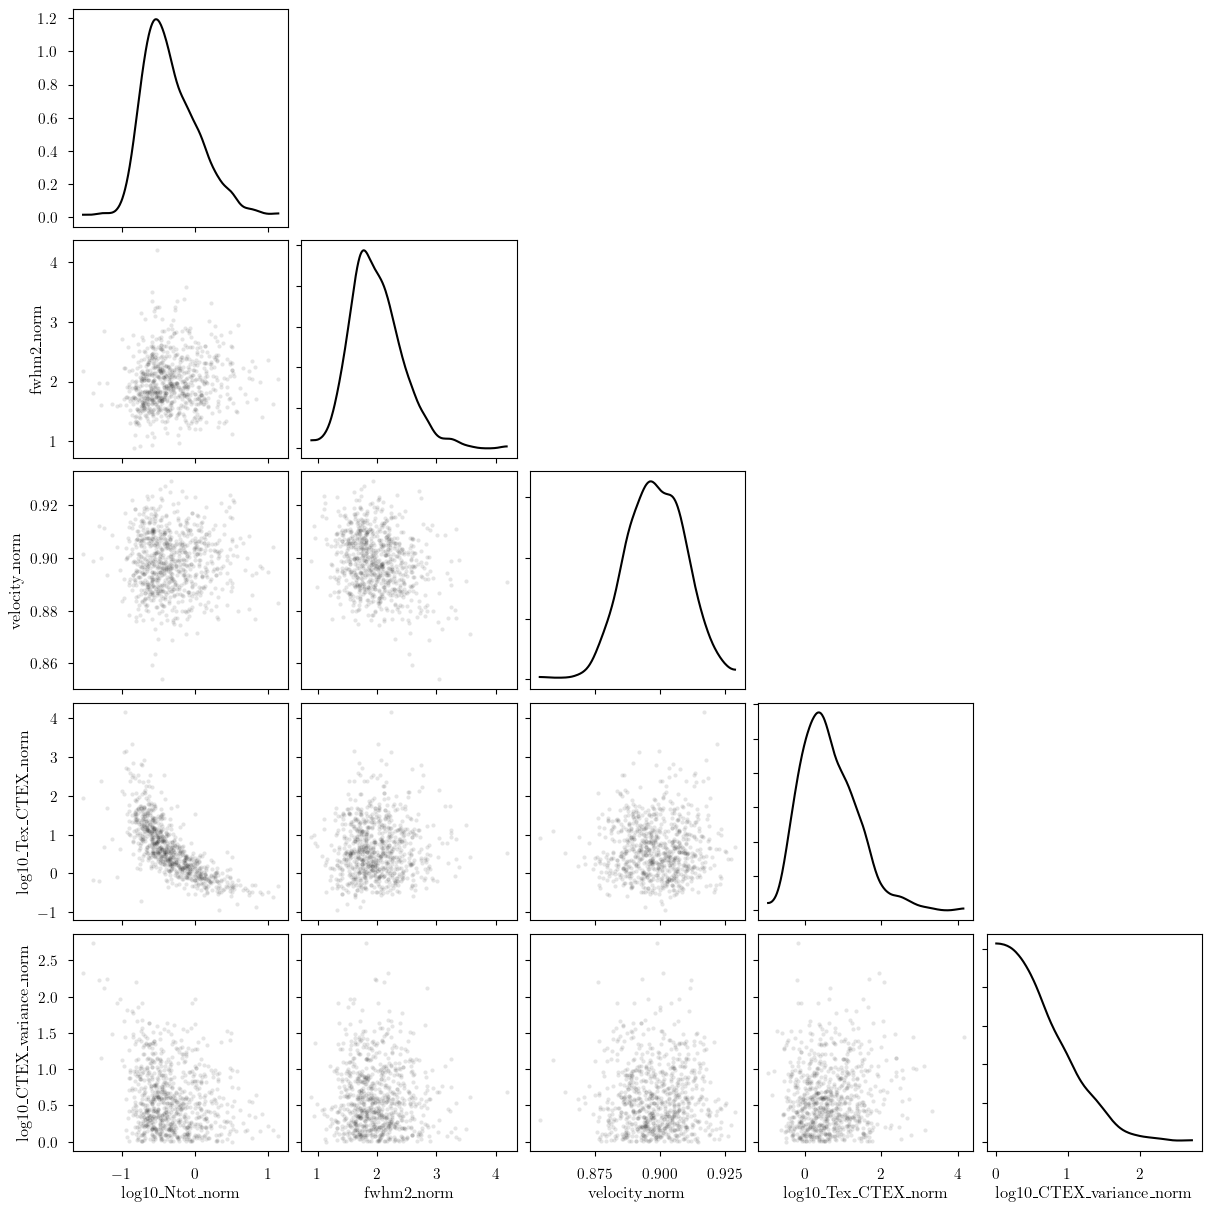

In [24]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=2, draw=slice(None, None, 10)), # samples
    var_names, # var_names to plot
    kind="scatter", # plot type
)

['log10_Ntot', 'fwhm2', 'velocity', 'log10_Tex_CTEX', 'log10_CTEX_variance', 'tau_total']


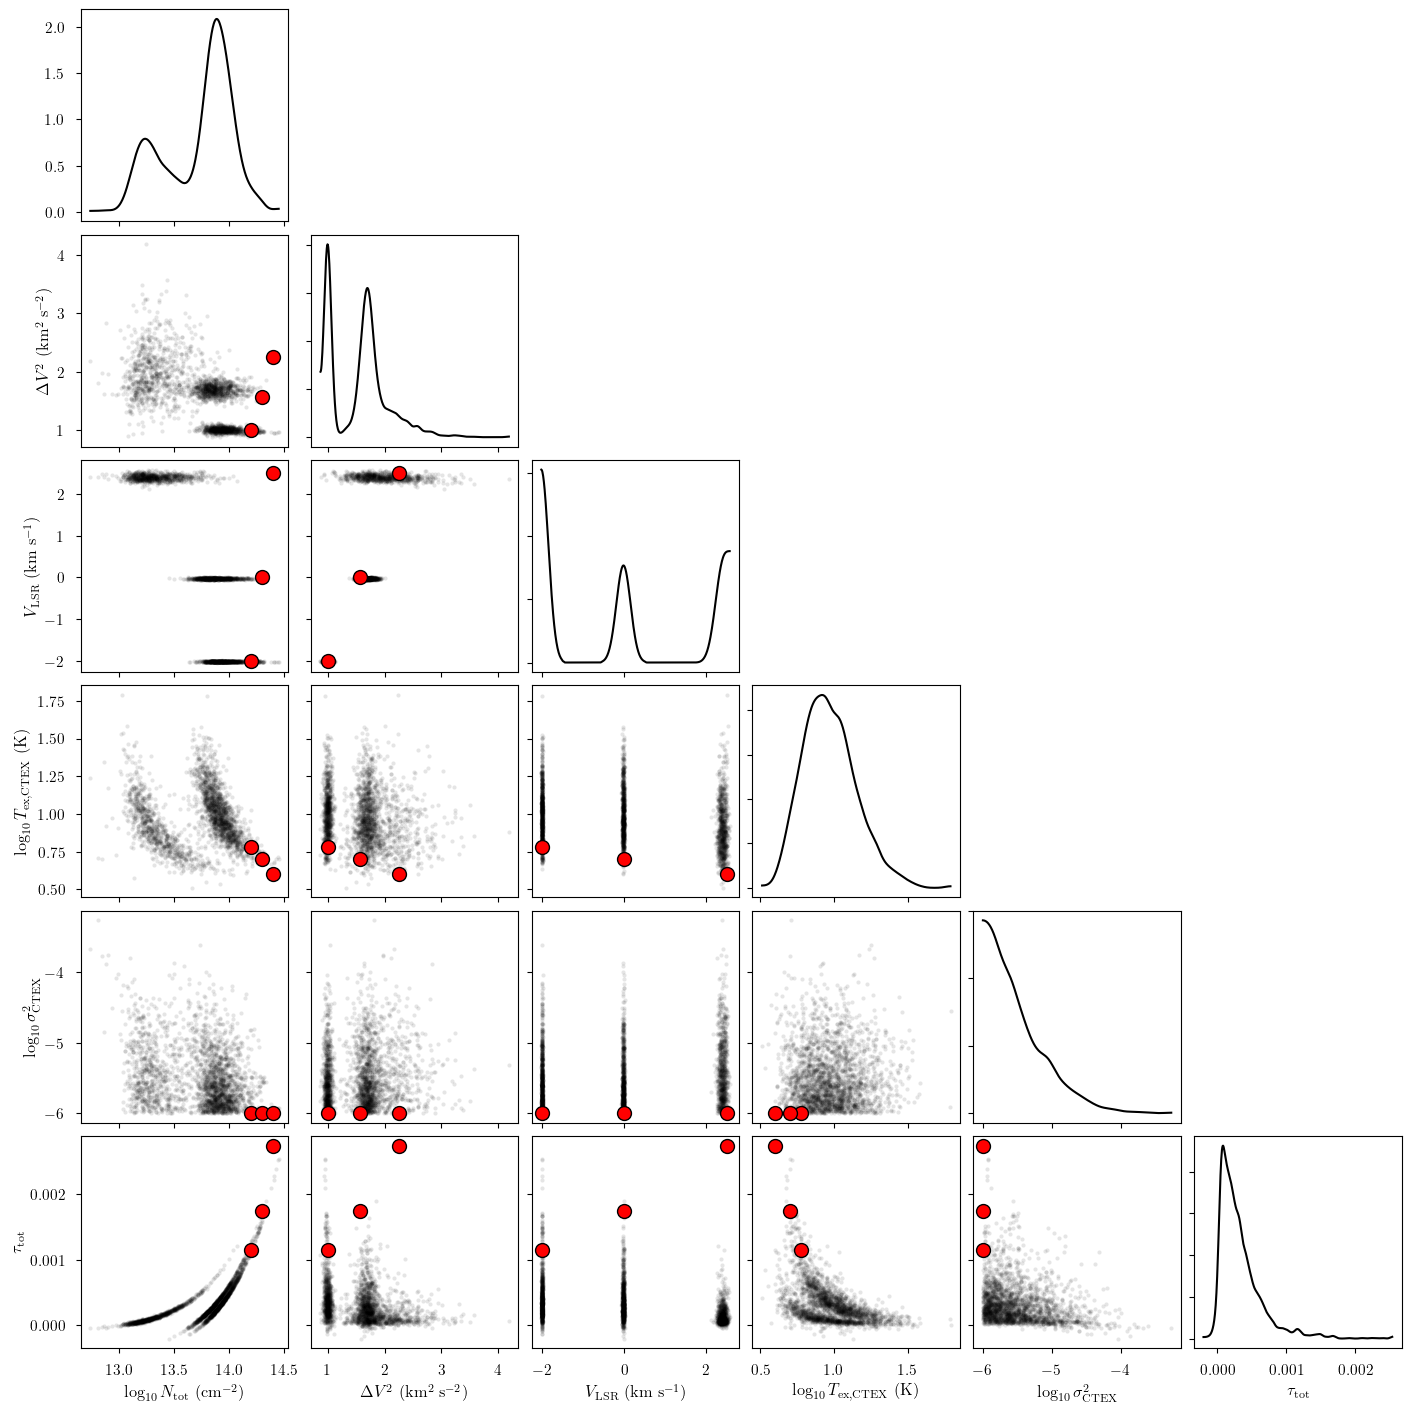

In [25]:
var_names = [
    param for param in model.cloud_deterministics + [p for p in model.cloud_freeRVs if "_norm" not in p]
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state"]))
]
print(var_names)

_ = plot_pair(
    model.trace.solution_0.sel(draw=slice(None, None, 10)), # samples
    var_names, # var_names to plot
    combine_dims=["cloud"], # concatenate clouds
    labeller=model.labeller, # label manager
    kind="scatter", # plot type
    reference_values=sim_params, # truths
)

In [26]:
# identify simulation cloud corresponding to each posterior cloud
sim_cloud_map = {}
for i in range(n_clouds):
    posterior_velocity = model.trace.solution_0['velocity'].sel(cloud=i).data.mean()
    match = np.argmin(np.abs(sim_params["velocity"] - posterior_velocity))
    sim_cloud_map[i] = match
sim_cloud_map

{0: np.int64(0), 1: np.int64(1), 2: np.int64(2)}

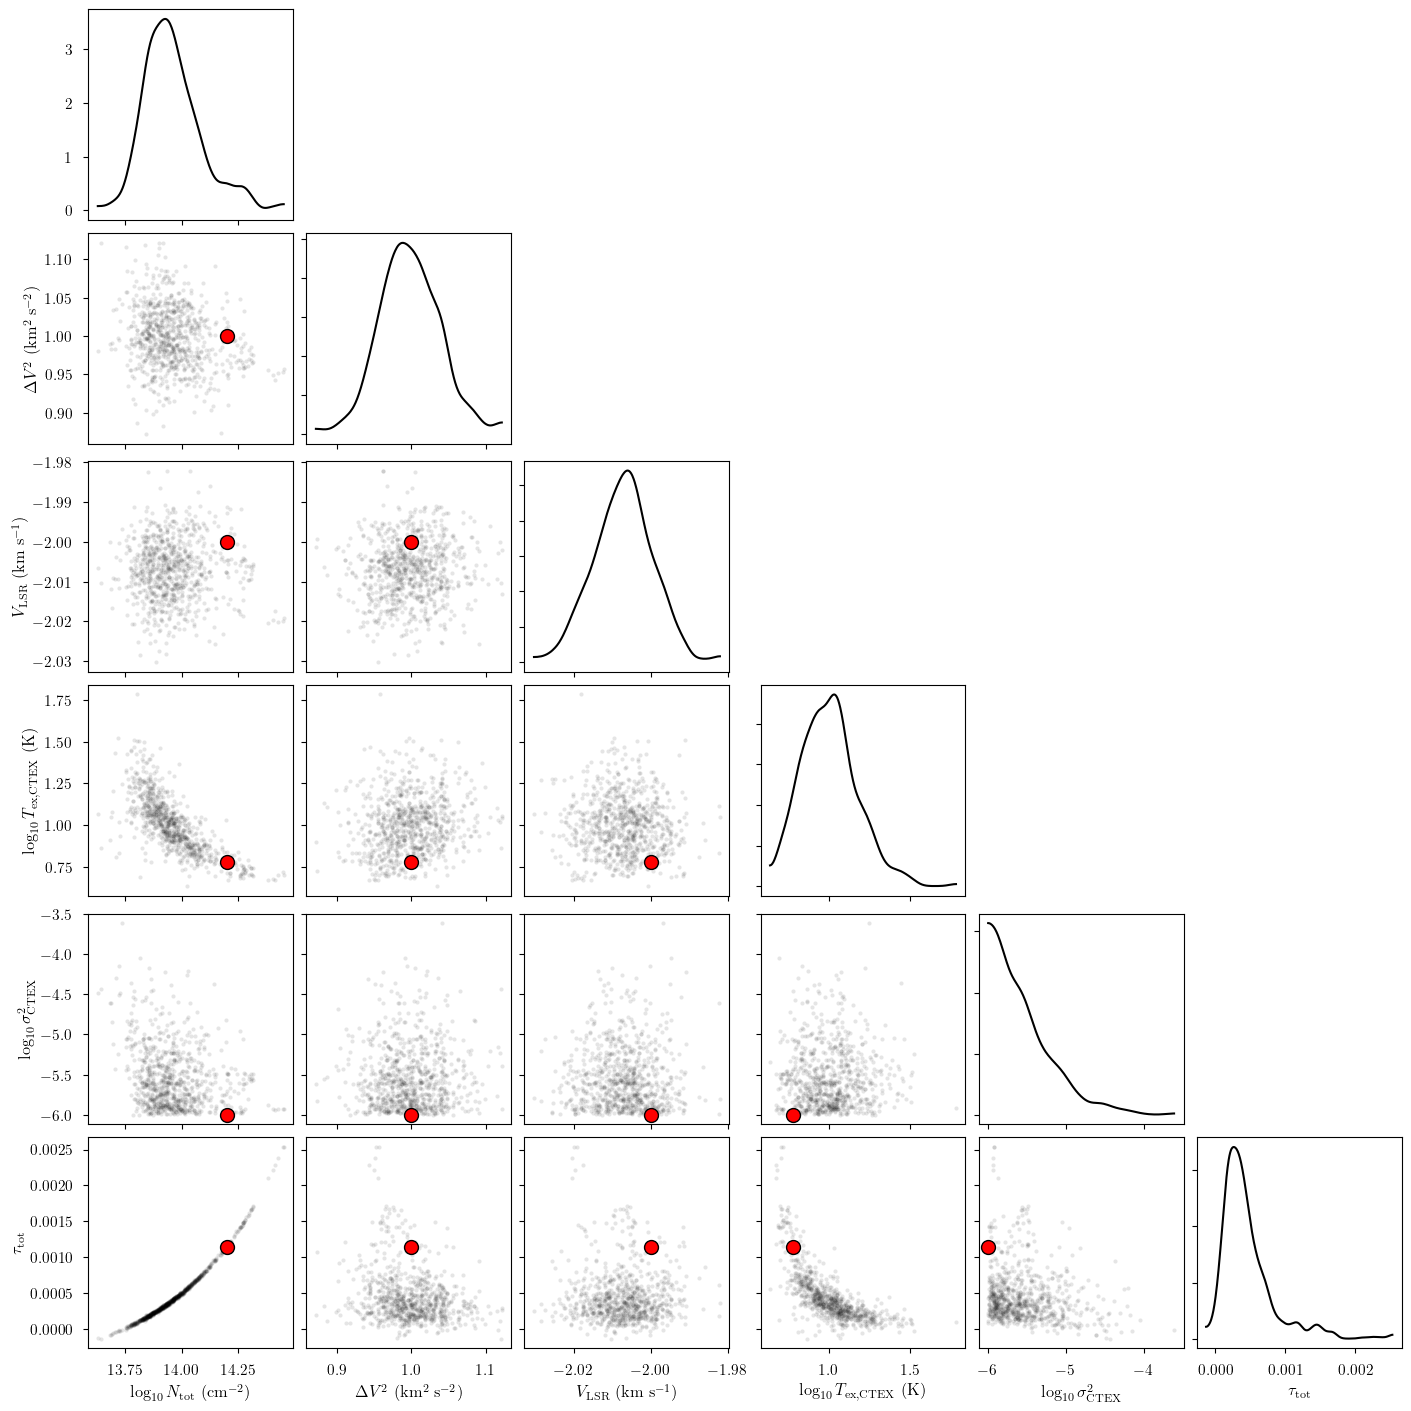

In [27]:
cloud = 0

# subset of sim_params
my_sim_params = {}
for var_name in var_names:
    my_sim_params[var_name] = sim_params[var_name][sim_cloud_map[cloud]]

_ = plot_pair(
    model.trace.solution_0.sel(cloud=cloud, draw=slice(None, None, 10)), # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
    kind="scatter", # plot type
    reference_values=my_sim_params, # truths
)

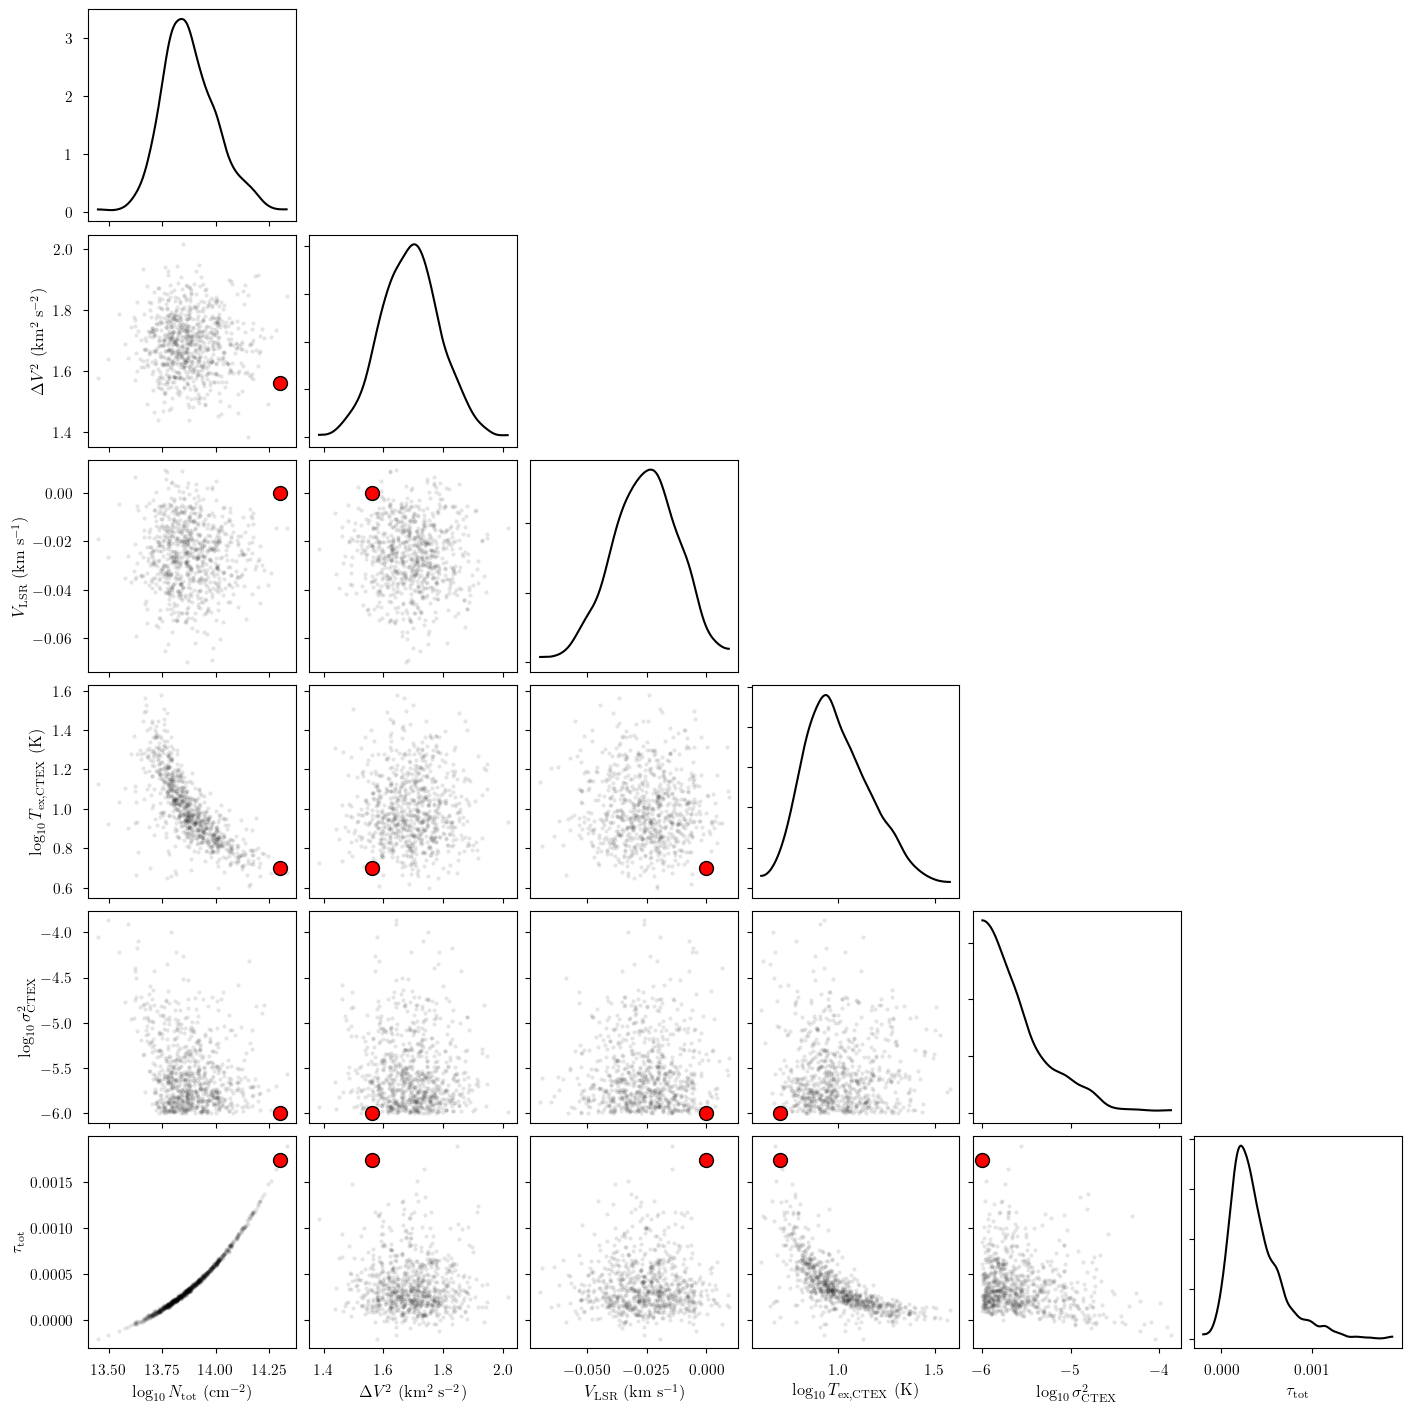

In [28]:
cloud = 1

# subset of sim_params
my_sim_params = {}
for var_name in var_names:
    my_sim_params[var_name] = sim_params[var_name][sim_cloud_map[cloud]]
    
_ = plot_pair(
    model.trace.solution_0.sel(cloud=cloud, draw=slice(None, None, 10)), # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
    kind="scatter", # plot type
    reference_values=my_sim_params, # truths
)

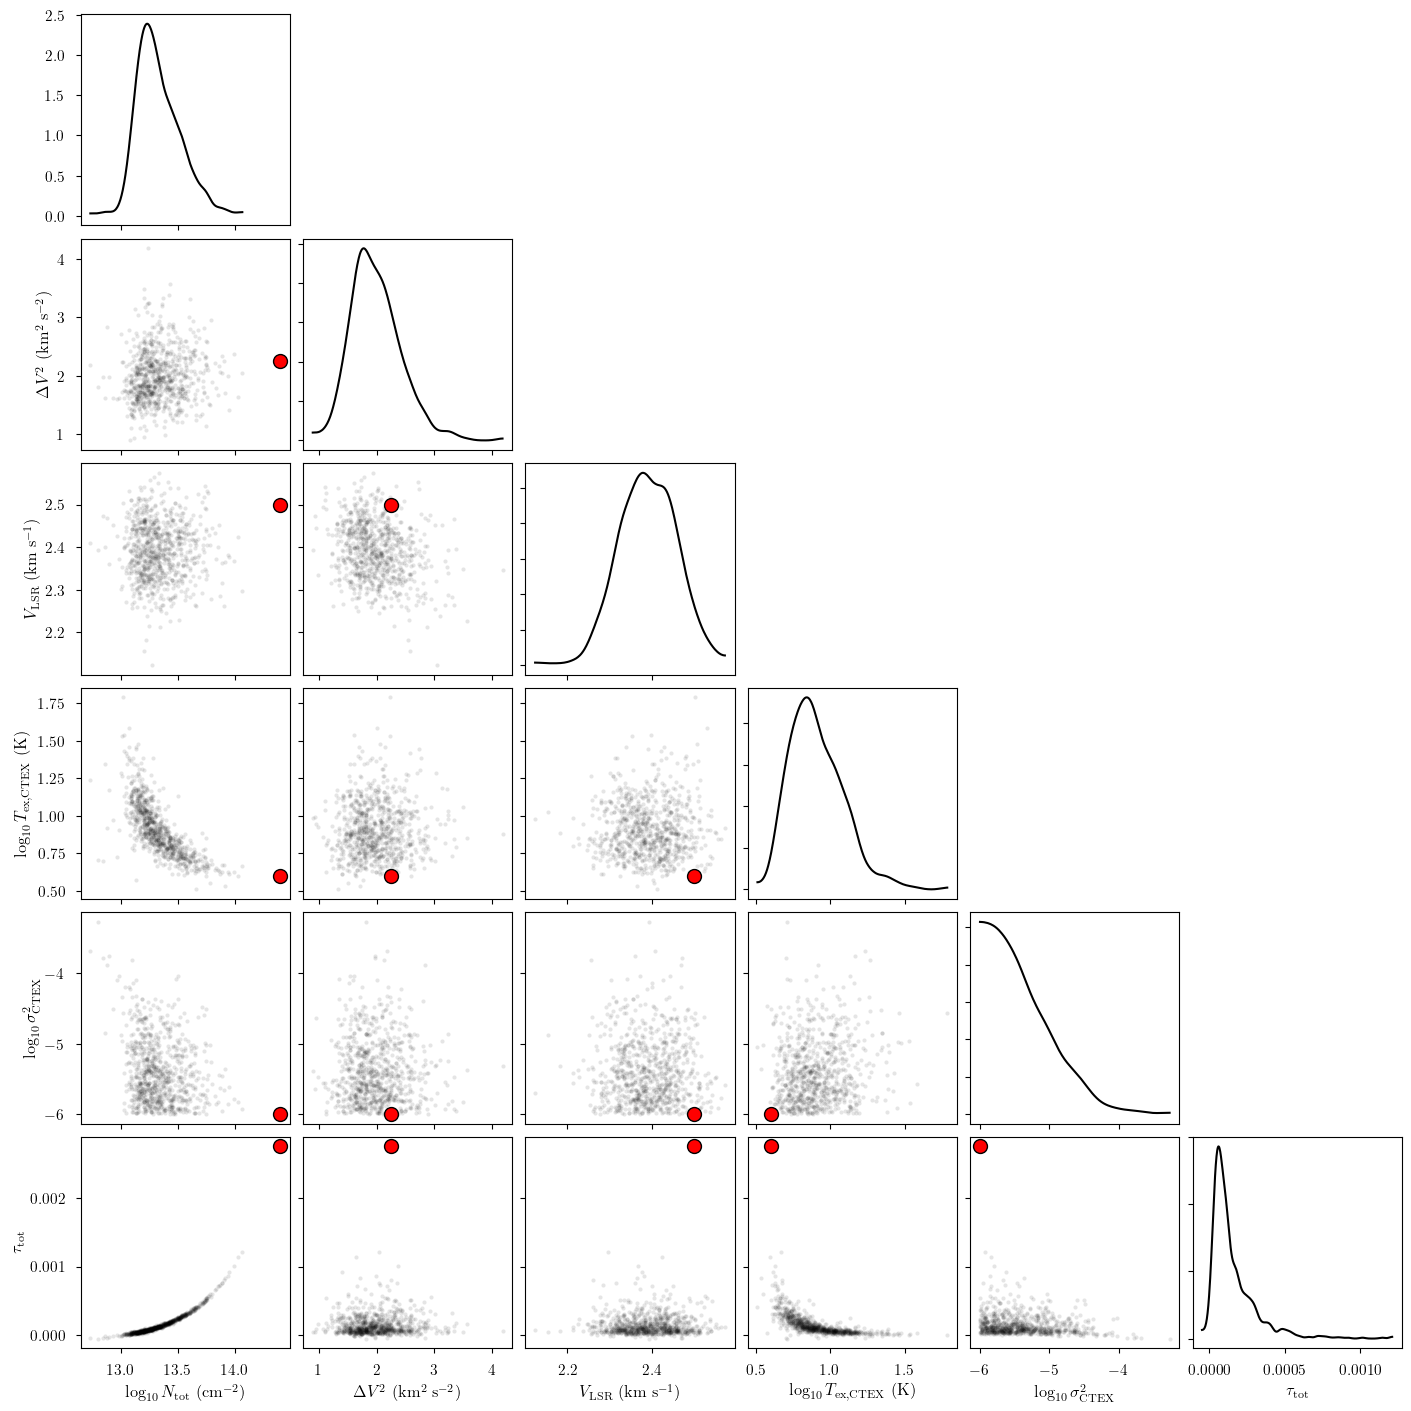

In [29]:
cloud = 2

# subset of sim_params
my_sim_params = {}
for var_name in var_names:
    my_sim_params[var_name] = sim_params[var_name][sim_cloud_map[cloud]]
    
_ = plot_pair(
    model.trace.solution_0.sel(cloud=cloud, draw=slice(None, None, 10)), # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
    kind="scatter", # plot type
    reference_values=my_sim_params, # truths
)

In [30]:
point_stats = az.summary(model.trace.solution_0, kind='stats')
print("BIC:", model.bic())
display(point_stats)

Dimension(s) '1612_dim_0' do not exist. Expected one or more of {'chain', '1667_dim_0', '1665_dim_0', '1612_observed_dim_0', 'draw', '1720_dim_0'}
BIC: inf


mean       sd  hdi_3%  hdi_97%
baseline_1612_norm[0]           -0.167    0.909  -1.830    1.475
baseline_1665_norm[0]            0.039    0.052  -0.055    0.140
baseline_1667_norm[0]            0.005    0.050  -0.092    0.099
baseline_1720_norm[0]            0.056    0.046  -0.033    0.141
log10_Ntot_norm[0]               0.918    0.262   0.487    1.484
log10_Ntot_norm[1]               0.755    0.253   0.330    1.273
log10_Ntot_norm[2]              -0.330    0.390  -0.944    0.493
log10_Tex_CTEX_norm[0]           1.028    0.691  -0.231    2.251
log10_Tex_CTEX_norm[1]           0.999    0.681  -0.180    2.274
log10_Tex_CTEX_norm[2]           0.607    0.690  -0.571    1.834
1612_unobserved[0]              -0.002    0.013  -0.026    0.024
1612_unobserved[1]              -0.002    0.013  -0.026    0.024
1612_unobserved[2]              -0.002    0.013  -0.026    0.025
1612_unobserved[3]              -0.002    0.014  -0.027    0.024
1612_unobserved[4]              -0.002    0.013  -0.026    0.024
1612_unobserved[5]              -0.002    0.013  -0.027    0.023
1612_unobserved[6]              -0.002    0.014  -0.027    0.023
1612_unobserved[7]              -0.002    0.013  -0.027    0.023
1612_unobserved[8]              -0.002    0.013  -0.027    0.023
1612_unobserved[9]              -0.002    0.014  -0.027    0.024
1612_unobserved[10]             -0.002    0.013  -0.026    0.024
1612_unobserved[11]             -0.002    0.013  -0.027    0.023
1612_unobserved[12]             -0.002    0.013  -0.028    0.023
1612_unobserved[13]             -0.002    0.013  -0.026    0.024
1612_unobserved[14]             -0.002    0.014  -0.026    0.025
1612_unobserved[15]             -0.001    0.014  -0.025    0.027
1612_unobserved[16]             -0.002    0.013  -0.027    0.023
1612_unobserved[17]             -0.002    0.014  -0.028    0.022
1612_unobserved[18]             -0.002    0.013  -0.026    0.025
1612_unobserved[19]             -0.001    0.013  -0.026    0.023
1612_unobserved[20]             -0.002    0.013  -0.026    0.024
1612_unobserved[21]             -0.002    0.014  -0.027    0.023
1612_unobserved[22]             -0.002    0.013  -0.027    0.023
1612_unobserved[23]             -0.002    0.013  -0.027    0.023
1612_unobserved[24]             -0.001    0.014  -0.027    0.024
1612_unobserved[25]             -0.002    0.014  -0.027    0.023
1612_unobserved[26]             -0.002    0.013  -0.026    0.024
1612_unobserved[27]             -0.002    0.013  -0.027    0.023
1612_unobserved[28]             -0.002    0.013  -0.026    0.024
1612_unobserved[29]             -0.002    0.014  -0.027    0.024
1612_unobserved[30]             -0.001    0.013  -0.028    0.023
1612_unobserved[31]             -0.001    0.014  -0.026    0.024
1612_unobserved[32]             -0.002    0.014  -0.027    0.024
1612_unobserved[33]             -0.002    0.014  -0.027    0.023
1612_unobserved[34]             -0.002    0.013  -0.027    0.024
1612_unobserved[35]             -0.002    0.013  -0.026    0.024
1612_unobserved[36]             -0.001    0.013  -0.026    0.024
1612_unobserved[37]             -0.002    0.013  -0.026    0.023
1612_unobserved[38]             -0.002    0.014  -0.027    0.024
1612_unobserved[39]             -0.002    0.013  -0.026    0.023
1612_unobserved[40]             -0.002    0.014  -0.027    0.023
1612_unobserved[41]             -0.002    0.013  -0.028    0.022
1612_unobserved[42]             -0.002    0.014  -0.026    0.024
1612_unobserved[43]             -0.002    0.014  -0.028    0.024
1612_unobserved[44]             -0.002    0.013  -0.027    0.023
1612_unobserved[45]             -0.002    0.014  -0.027    0.024
1612_unobserved[46]             -0.002    0.014  -0.028    0.024
1612_unobserved[47]             -0.001    0.013  -0.026    0.025
1612_unobserved[48]             -0.002    0.013  -0.027    0.022
1612_unobserved[49]             -0.002    0.013  -0.027    0.023
1612_unobserved[50]             -0.002    0.013  -0.025    0.025
1612